In [33]:
%cd ../

/Users/sarchey1/paper


In [2]:
import warnings
warnings.simplefilter('ignore')

## Stochastic Block Model Experiment

Before geting into the experiment details, let's review algorithm 1 and the primal and dual updates.

### Algorithm 1

![title](../gradient_federated.png)

In [220]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error


def algorithm_1(K, D, weight_vec, features, true_labels, samplingset, lambda_lasso, calculate_score=True,
               train_seed=1):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param features: a list containing the local datapints of the nodes
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    np.random.seed(train_seed)
    E, N = D.shape
    m, n = features[0].shape
    
    iterations = K
    
    L = D.T * weight_vec @ D
    ub_L = lambda_lasso*2*np.diag(L).max()
#     if prints:
#         print("ub for lambda * L", ub_L)

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        prev_w = np.copy(new_w)
        # line 2 of Gradient descent for networked FL
        new_w = np.array([np.zeros(n) for i in range(N)])

        # line 3 of Gradient descent for networked FL
        for i in range(N):
            if i in samplingset:  
                # line 4 of Gradient descent for networked FL
#                 optimizer = datapoints[i]['optimizer']
#                 new_w[i] = 1/m * optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], prev_w[i], datapoints[i]['degree'])
                
                # line 4 of Gradient descent for networked FL
                var = np.dot(features[i], prev_w[i]) - true_labels[i]
                new_w[i] = 1/m * np.dot(features[i].T, var)


        # line 6 of Gradient descent for networked FL
        for e in range(E):
            i = np.where(D[e]==1)[0]
            j = np.where(D[e]==-1)[0]
            
            # line 7 of Gradient descent for networked FL
            tilde_w = lambda_lasso * weight_vec[e] * (prev_w[j] - prev_w[i])
            
            # line 8 of Gradient descent for networked FL
            new_w[i] = new_w[i] - tilde_w
            
            # line 9 of Gradient descent for networked FL
            new_w[j] = new_w[j] + tilde_w
            

        # line 11 of Gradient descent for networked FL
        alpha = []
        for i in range(N):
            ub = lambda_lasso * L[i,i]
            if i in samplingset:
                x = features[i]
                c = 1/m * x.T @ x
                ub += np.sum(np.abs(c), axis=1).max()
            lr = 1 / ub
            alpha.append([lr for i in range(n)])
        alpha = np.array(alpha)
#         print('alpha', alpha)
        
        
        new_w = prev_w - alpha * new_w
#         print(new_w.shape)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            alg1_score = get_algorithm1_w_MSE(new_w, samplingset.copy(), datapoints.copy())['total']
            iteration_scores.append(alg1_score)
            
#             if iterk > 1:
#                 print(iterk, iteration_scores[-2] - iteration_scores[-1], iteration_scores[-1], iteration_scores[-2])
            if iterk > 10 and (iteration_scores[-2] - iteration_scores[-1])/iteration_scores[-2] < 0.005:
                iterations = iterk
                break

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w, iterations


### Joona's implementation

In [62]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F


import torch

class TorchLinearModel(torch.nn.Module):
    def __init__(self, n, lr, ifca_init=True):
        super(TorchLinearModel, self).__init__()
        self.lr = lr
        self.linear = torch.nn.Linear(n, 1, bias=False)
        if ifca_init:
            self.linear.weight.data = torch.tensor(np.random.binomial(1, 0.5, size=(1, n)).astype(np.float32))*1.0
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
    
    def weight(self):
        return self.linear.weight
    
    def update_weights(self):
        with torch.no_grad():
            self.linear.weight.data -= self.lr * self.linear.weight.grad.clone()
        self.zero_grad()


def joonas_algorithm_1(K, D, weight_vec, features, true_labels, samplingset, lambda_lasso, calculate_score=False, 
                      train_seed=1, ifca_init=True):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param features: a list containing the local datapints of the nodes
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    np.random.seed(train_seed)
    
    E, N = D.shape
    m, n = features[0].shape

    # starting algorithm 1

    # step size, 0.0001
    # last 0.05
    
    D = torch.Tensor(D)
    weight_vec = torch.Tensor(weight_vec)
    
         
    L = D.T * weight_vec @ D
    ub_L = lambda_lasso*2*np.diag(L).max()
#     if prints:
#         print("ub for lambda * L", ub_L)
    
    iteration_scores = []
    
    model_params = list()
    models = []
    for i in range(N):
        ub = lambda_lasso * L[i,i]
        if i in samplingset:
            x = features[i]
            m, n = x.shape
            c = 1/m * x.T @ x
            ub += np.sum(np.abs(c), axis=1).max()
        lr = 1 / ub
        model = TorchLinearModel(n, lr, ifca_init)
        models.append(model)
        model_params += list(model.parameters())
    
    prev_loss = 0
    iterations = K
                    
    for iterk in range(K):
        # Shared loss over all nodes
        loss = 0
        # f(w) (training error/loss)
        for i in samplingset:
            x_i = torch.Tensor(features[i])
            y_i = torch.Tensor(true_labels[i]).reshape(-1, 1)
            y_pred = models[i](x_i)
            loss1 = F.mse_loss(y_pred, y_i)
            loss += loss1
                
        # GTV
        # weight_vec is A (edge weights)
        # D is sort of adjacency matrix? +1 on j and -1 on i
        # new_w has the current weights
        new_w = torch.cat([models[i].linear.weight for i in range(N)])
        # w_j - w_i = D @ new_w
        norm_squared = torch.square(torch.linalg.norm(D @ new_w, dim=1))
        loss2 = lambda_lasso * torch.dot(weight_vec, norm_squared)
        loss += loss2
        loss *= 0.5
        
#         print("epoch:", iterk)
#         print("loss", loss.item())
        if prev_loss - loss < 0.0005 and prev_loss - loss >= 0:
            iterations = iterk
            break
        else:
            prev_loss = loss
        
        loss.backward()
        for i in range(N):
            models[i].update_weights()
        

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            score = get_algorithm1_w_MSE(new_w[i], samplingset.copy(), datapoints.copy())['total']
            iteration_scores.append(score)
    
    new_w = np.array([models[i].linear.weight.data.numpy() for i in range(N)]).reshape((N, -1))

    return iteration_scores, new_w, iterations



As the result we compare the MSE of Algorithm 1 with plain linear regression 
and decision tree regression

In [5]:
# %load results/compare_results.py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


def get_algorithm1_MSE(all_features, labels, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(all_features)) if i not in samplingset]

    true_labels = []
    pred_labels = []
    for i in range(len(all_features)):
        features = np.array(all_features[i])
        label = np.array(labels[i])
        true_labels.append(label)

        pred_labels.append(np.dot(features, predicted_w[i]))

    pred_labels = np.array(pred_labels)
    true_labels = np.array(true_labels)

    alg1_MSE = {'total': mean_squared_error(true_labels, pred_labels),
                'train': mean_squared_error(true_labels[samplingset], pred_labels[samplingset]),
                'test': mean_squared_error(true_labels[not_samplingset], pred_labels[not_samplingset])}

    return alg1_MSE

def get_algorithm1_w_MSE(predicted_w, samplingset, datapoints):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(datapoints)) if i not in samplingset]
    true_w = []
    for i in datapoints:
        true_w.append(datapoints[i]['w'])
    
    predicted_w = np.array(predicted_w)
    true_w = np.array(true_w)

    alg1_MSE = {'total': mean_squared_error(true_w, predicted_w),
                'train': mean_squared_error(true_w[samplingset], predicted_w[samplingset]),
                'test': mean_squared_error(true_w[not_samplingset], predicted_w[not_samplingset])}

    return alg1_MSE


def get_linear_regression_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return linear_regression_MSE : the MSE of linear regression for all the nodes, the samplingset and other nodes (test set)
    '''

    model = LinearRegression().fit(x[samplingset], y[samplingset])
    pred_y = model.predict(x)

    linear_regression_MSE = {'total': mean_squared_error(y, pred_y),
                             'train': mean_squared_error(y[samplingset],
                                                         pred_y[samplingset]),
                             'test': mean_squared_error(y[not_samplingset],
                                                        pred_y[not_samplingset])}

    return linear_regression_MSE


def get_decision_tree_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return decision_tree_MSE : the MSE of decision tree for all the nodes, the samplingset and other nodes (test set)
    '''

    max_depth = 2

    regressor = DecisionTreeRegressor(max_depth=max_depth)
    regressor.fit(x[samplingset], y[samplingset])
    pred_y = regressor.predict(x)

    decision_tree_MSE = {'total': mean_squared_error(y, pred_y),
                         'train': mean_squared_error(y[samplingset],
                                                     pred_y[samplingset]),
                         'test': mean_squared_error(y[not_samplingset],
                                                    pred_y[not_samplingset])}
    return decision_tree_MSE


def get_scores(features, labels, primal_dual_w, predicted_w, joona_w, fl_w, samplingset, others=True):
    N = len(features)
    '''
    N : the total number of nodes
    '''

    # calculate algorithm1 MSE
    alg_1_score = get_algorithm1_MSE(features, labels, predicted_w, samplingset)
    primal_dual_score = get_algorithm1_MSE(features, labels, primal_dual_w, samplingset)
    joonas_score = get_algorithm1_MSE(features, labels, joona_w, samplingset)
    fl_score = get_algorithm1_MSE(features, labels, fl_w, samplingset)
    
    linear_regression_score = None
    decision_tree_score = None

    if others:
        # prepare the data for calculating the linear regression and decision tree regression MSEs
        X = []
        '''
        X: an array containing the features of all the nodes
        '''
        true_labels = []
        '''
        true_labels: an array containing the labels of all the nodes
        '''
        for i in range(len(datapoints)):
            X.append(np.array(datapoints[i]['features']))
            true_labels.append(np.array(datapoints[i]['label']))

        X = np.array(X)
        true_labels = np.array(true_labels)
        m, n = X[0].shape

        x = X.reshape(-1, n)
        y = true_labels.reshape(-1, 1)

        reformated_samplingset = []
        for item in samplingset:
            for i in range(m):
                reformated_samplingset.append(m * item + i)
        reformated_not_samplingset = [i for i in range(m * N) if i not in reformated_samplingset]
        
        # calculate linear regression MSE
        linear_regression_score = get_linear_regression_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

        # calculate decision tree MSE
        decision_tree_score = get_decision_tree_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

    return alg_1_score, joonas_score, primal_dual_score, fl_score, linear_regression_score, decision_tree_score



### SBM with Two Clusters

This SBM has two clusters $|C_1| = |C_2| = 100$.
Two nodes within the same cluster are connected by an edge with probability `pin=0.5`, 
and two nodes from different clusters are connected by an edge with probability `pout=0.01`. 
Each node $i \in V$ represents a local dataset consisting of feature vectors $x^{(i,1)}, ... , x^{(i,5)} \in R^2$.
The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ~ N(0,I).
The labels $y_1^{(i)}, . . . , y_5^{(i)} \in R$ for each node $i \in V$
are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon = 0$. 
The tuning parameter $\lambda$ in algorithm1 
is manually chosen, guided by the resulting MSE, as $\lambda=0.01$ for norm1 and norm2 and also $\lambda=0.05$ for mocha penalty function. 
To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes and use the rest as test set. As the result we compare the mean MSE of Algorithm 1 with plain linear regression and decision tree regression with respect to the different random sampling sets.

In [9]:
def get_sbm(c=2, p1 = 0.4, p2 = 0.1, n_nodes = 10, n_data = 100, d_data = 1):
    N_c = n_nodes
    N = N_c * c
    B = []
    weight_vec = []
    
    for i in range(c):
        for idx1 in range(n_nodes * i, n_nodes * (i + 1)):
            for idx2 in range(idx1 + 1, n_nodes * (i + 1)):
                if p1 > np.random.random():
                    b = np.zeros(N)
                    if idx1 < idx2:
                        b[idx1] = 1
                        b[idx2] = -1
                    else:
                        b[idx1] = -1
                        b[idx2] = 1
                    weight_vec.append(1)
                    B.append(b)
                
    # Add edges between components (intercomponent edges)
    for i in range(c):
        for idx1 in range(n_nodes * i, n_nodes * (i + 1)):
            for i2 in range(i+1, c):
                for idx2 in range(n_nodes * i2, n_nodes * (i2 + 1)):
                    if p2 > np.random.random():
                        b = np.zeros(N)
                        if idx1 < idx2:
                            b[idx1] = 1
                            b[idx2] = -1
                        else:
                            b[idx1] = -1
                            b[idx2] = 1
                        weight_vec.append(1)
                        B.append(b)
     
    B = np.array(B)
    weight_vec = np.array(weight_vec)
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    
    datapoints = {}
    true_labels = []
    all_features = []
    # weights to generate labels from data
    ws = np.arange(1,c+1) * 10
    ws = [[w for i in range(d_data)] for w in ws]
    
    for i in range(c):
        w = ws[i]
        for idx in range(n_nodes * i, n_nodes * (i + 1)):
            # x sim N(0, I)
            features = np.random.normal(loc=0.0, scale=1.0, size=(n_data, d_data))
#             features = np.random.normal(scale=np.ones(n_data, d_data))
            # y = w x + noise
            # w is same for all nodes in a component
            # noise sim N(0, 0.4)
            noise = np.random.normal(scale=np.ones(n_data) * 0.4)
#             label = w * features + noise
            label = np.dot(features, w)  + noise
            true_labels.append(label)       

            datapoints[idx] = {
                'features': features,
                'label': label,
                'w': w,
                'degree': node_degrees[i],
            }
            
            all_features.append(features)
            
    return B, weight_vec, np.array(all_features), np.array(true_labels), datapoints

Plot the MSE with respect to the different random sampling sets for each penalty function, the plots are in the log scale

## Results 

### Number of features: 2   
### Number of datapoints per node: 5

In [160]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


K = 1000

# B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)
B, weight_vec, features, true_labels, datapoints = get_sbm(c=2, p1=1.0, p2=0.0, n_nodes=10, n_data=5, d_data=2)


num_tries = 5

from joblib import Parallel, delayed
import multiprocessing
def fun(K, B, weight_vec, features, datapoints, true_labels):
    E, N = B.shape
    samplingset = random.sample([j for j in range(N)], k=int(0.5* N)) 
    _, predicted_w, alg1_iters = algorithm_1(K, B.copy(), weight_vec.copy(), 
                                 features.copy(), 
                                 true_labels.copy(), 
                                 samplingset.copy(), 
                                 lambda_lasso=0.1)
    _, joona_w, joona_iters = joonas_algorithm_1(K, B.copy(), weight_vec.copy(), 
                                       features.copy(), 
                                       true_labels.copy(), 
                                       samplingset, 
                                       lambda_lasso=0.1)
    
    alg1_score = get_algorithm1_w_MSE(predicted_w, samplingset.copy(), datapoints.copy())
    joona_score = get_algorithm1_w_MSE(joona_w, samplingset.copy(), datapoints.copy())

    return alg1_score, joona_score, alg1_iters, joona_iters


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

alg1_scores = []
alg1_iters = []
joonas_scores = []
joona_iters = []
for i in range(num_tries):
    alg1_score, joonas_score, alg1_iter, joona_iter = fun(K, B, weight_vec, features, datapoints, true_labels)
    alg1_scores.append(alg1_score)
    joonas_scores.append(joonas_score)
    alg1_iters.append(alg1_iter)
    joona_iters.append(joona_iter)



algorithm 1: 
 mean train MSE: 0.013136339976582843 
 mean test MSE: 0.008631217869269873

joonas algorithm 1: 
 mean train MSE: 0.014247320560671139 
 mean test MSE: 0.009977119123223018



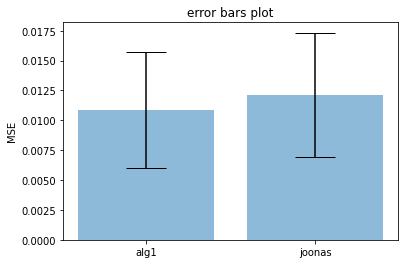

In [161]:
labels = ['alg1', 'joonas']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))
print()


print('joonas algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in joonas_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in joonas_scores]))
print()

    
alg1_norm1_score = [item['total'] for item in alg1_scores]
joonas_score = [item['total'] for item in joonas_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(joonas_score), 
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(joonas_score), 
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

## Joona's implementation accuracy

In [244]:
p1s = np.linspace(0.1, 0.9, 9)
p2s = np.linspace(0.1, 0.7, 7)

def experiment(iterk = 5, c = 2):
    K = 400
    
    alg1_scores = defaultdict(list)
    n_nodes = 50
    scores_test = np.zeros((9,7,iterk))
    scores_total = np.zeros((9,7,iterk))
    pred_ws = defaultdict(list)
    n_iters = np.zeros((9,7,iterk))
    
    
    lambda_lasso = 0.05

    for k in range(iterk):
        for p1i in range(len(p1s)):
            p1 = p1s[p1i]
#             print(p1)
            for p2i in range(len(p2s)):
                p2 = p2s[p2i]
                
                B, weight_vec, all_features, true_labels, datapoints = get_sbm(c, p1=p1, p2=p2, n_nodes=n_nodes)
                E, N = B.shape

                samplingset = random.sample([i for i in range(N)], k=int(0.5 * N))
            
                _, predicted_w, iters = joonas_algorithm_1(K, B, weight_vec, all_features, true_labels, samplingset, lambda_lasso)
        

                pred_ws[p1,p2].append(predicted_w)
            
                alg1_score = get_algorithm1_w_MSE(predicted_w, samplingset.copy(), datapoints.copy())
                alg1_scores[f'{p1}{p2}'].append(alg1_score)

                scores_test[p1i,p2i,k] = alg1_score['test']
                scores_total[p1i,p2i,k] = alg1_score['total']
                n_iters[p1i,p2i,k] = iters
    return alg1_scores, scores_test, scores_total, n_iters, pred_ws


In [245]:
expc2 = experiment(c = 2)


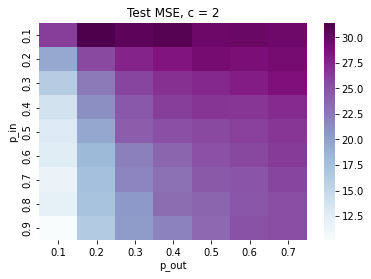

In [246]:

import seaborn as sns
sns.heatmap(expc2[1].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Test MSE, c = 2")
plt.show()

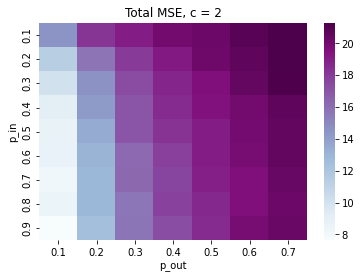

In [247]:
sns.heatmap(expc2[2].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), robust=False, cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Total MSE, c = 2")
plt.show()

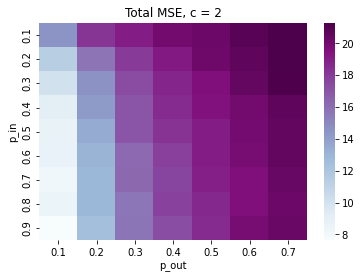

In [248]:
sns.heatmap(expc2[2].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), robust=False, cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Total MSE, c = 2")
plt.show()

## Convergence speed w.r.t p1, p2


We measure the convergence speed of the networked algorithm with the number of iterations it takes to converge w.r.t $p1$, $p2$.
Convergence is reached when the train MSE difference of two subsequent iterations is less than $\epsilon = 0.005$.
It is worth noting that the number of clusters affects the convergence speed as well as it adds $n_{nodes}$ more nodes to the graph.
However, the number of iterations it takes to converge is not universal as it also depends on the optimizer of choice and the learning rate.
Yet, the results should give idea relative to the settings about the convergence speed.

Should also analyze big O for iteration time?

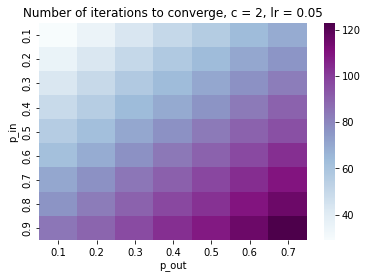

In [243]:
sns.heatmap(expc2[3].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Number of iterations to converge, c = 2, lr = 0.05")
plt.show()

## My implementation accuracy

In [231]:
p1s = np.linspace(0.1, 0.9, 9)
# p1s = np.linspace(0.1, 0.9, 3)
p2s = np.linspace(0.1, 0.7, 7)
# p2s = np.linspace(0.1, 0.7, 3)
lambda_lasso = 0.1

def my_experiment(iterk = 5, c = 2):
    K = 400
    lambda_lasso = 0.1
    
    alg1_scores = defaultdict(list)
    n_nodes = 50
    pred_ws = defaultdict(list)
    scores_test = np.zeros((9,7,iterk))
    scores_total = np.zeros((9,7,iterk))
    n_iters = np.zeros((9,7,iterk))

    for k in range(iterk):
        for p1i in range(len(p1s)):
            p1 = p1s[p1i]
#             print(p1)
            for p2i in range(len(p2s)):
                p2 = p2s[p2i]
                
                B, weight_vec, all_features, true_labels, datapoints = get_sbm(c, p1=p1, p2=p2, n_nodes=n_nodes)
                E, N = B.shape
                samplingset = random.sample([i for i in range(N)], k=int(0.5 * N))
            
                _, predicted_w, iters = algorithm_1(K, B, weight_vec, all_features, true_labels, samplingset, lambda_lasso)
        
#                 alg1_score, torch_linear_score, linear_regression_score, decision_tree_score = get_scores(datapoints, predicted_w, samplingset, c, n_nodes)
                pred_ws[p1,p2].append(predicted_w)
                alg1_score = get_algorithm1_MSE(all_features, true_labels, predicted_w, samplingset)
                alg1_scores[f'{p1}{p2}'].append(alg1_score)

                scores_test[p1i,p2i,k] = alg1_score['test']
                scores_total[p1i,p2i,k] = alg1_score['total']
                n_iters[p1i,p2i,k] = iters
    return alg1_scores, scores_test, scores_total, n_iters, pred_ws

my_expc2 = my_experiment(c = 2)
# new_my_expc2 = my_experiment(c = 2)



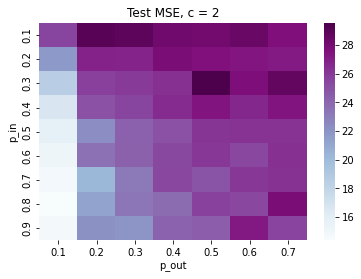

In [232]:
sns.heatmap(my_expc2[1].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Test MSE, c = 2")
plt.show()

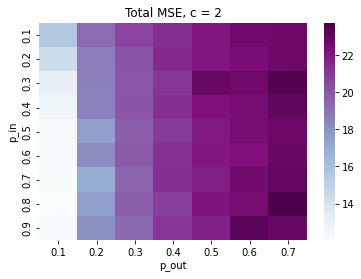

In [233]:
sns.heatmap(my_expc2[2].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), robust=False, cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Total MSE, c = 2")
plt.show()

## Convergence speed w.r.t p1, p2

We measure the convergence speed of the networked algorithm with the number of iterations it takes to converge w.r.t $p1$, $p2$.
Convergence is reached when the train MSE difference of two subsequent iterations is less than $\epsilon = 0.005$.
It is worth noting that the number of clusters affects the convergence speed as well as it adds $n_{nodes}$ more nodes to the graph.
However, the number of iterations it takes to converge is not universal as it also depends on the optimizer of choice and the learning rate.
Yet, the results should give idea relative to the settings about the convergence speed.

Should also analyze big O for iteration time?

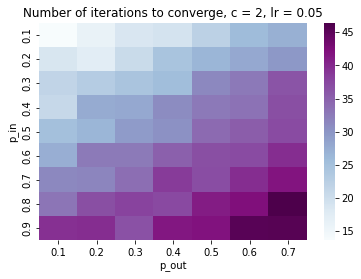

In [234]:
sns.heatmap(my_expc2[3].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Number of iterations to converge, c = 2, lr = 0.05")
plt.show()